In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from typing import *
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
with open('config.yml') as config_file:
    config = yaml.load(config_file, Loader = yaml.FullLoader)

## Steps for reproducing results in this notebook:

Please, make sure that `data/risk_factors_cervical_cancer.csv` file exists. If it's not, please download it by the [link](https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv) or use the command below:
```shell
$ wget https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv
```

In [3]:
# prettify graphs
def prettify_ax(ax: plt.Axes) -> None:
    ''' make an axis pretty '''
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_frameon = True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color = 'w', linestyle = '-', linewidth = 1)
    ax.tick_params(direction = 'out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize: tuple[int, int] = (6, 4), **kwargs) -> tuple[plt.Figure, plt.Axes]:
    ''' single prettified axis '''
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

In [4]:
def roc_plt(y_test: list[any], decs: list[any], col: int = 3) :
    roc = roc_curve(y_test[:,col], decs)
    auc = roc_auc_score(y_test[:,col], decs)
    f, a = simple_ax(figsize = (10, 6))
    plt.plot(roc[0], roc[1], linewidth = 2)
    plt.plot([0, 1], [0, 1], color = 'r', linestyle = '--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    a.text(0.8, 0.1, 'AUC = %f'%auc, fontsize = 12, bbox = {'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    return plt

def miss_plt(missings: list[any], data: list[any]):
    plt.figure(figsize = (8, 6))
    ind = np.arange(len(missings))
    width = 0.35
    p1 = plt.bar(ind, missings, width)
    p2 = plt.bar(ind, 1 - missings, width, bottom = missings)
    plt.ylabel('Fraction')
    plt.title('Fraction missing data by column')
    plt.xticks(ind, data.columns.values, rotation = 90)
    plt.legend((p1[0], p2[0]), ('Missing', 'Not missing'))
    return plt

In [5]:
# read in data
data = pd.read_csv('data/risk_factors_cervical_cancer.csv', na_values = '?')
print('Shape: ', data.shape)
data.head()

Shape:  (858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


*We can see that there are missing values in the dataset, we first investigate these.*

## Missing Data

In [6]:
# determine missing values per column
missings = np.zeros(data.shape[1])
for colnum in range(data.shape[1]):
    missings[colnum] = data.iloc[:,colnum].isnull().sum() / data.shape[0]

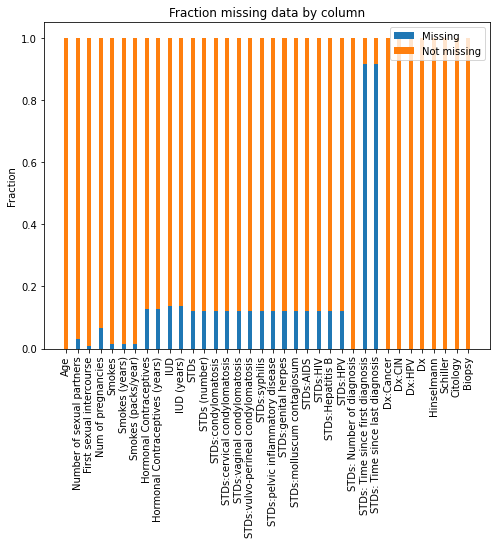

In [7]:
plt = miss_plt(missings, data)
plt.savefig('plots/col_miss1.png')
plt.show()

*We will first drop the two columns with many missing values. We will then investigate two methods of filling the other missing values.*

In [8]:
# drop STD columns as it contains too many missing values
data_drop = data.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis = 1)
data_drop.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


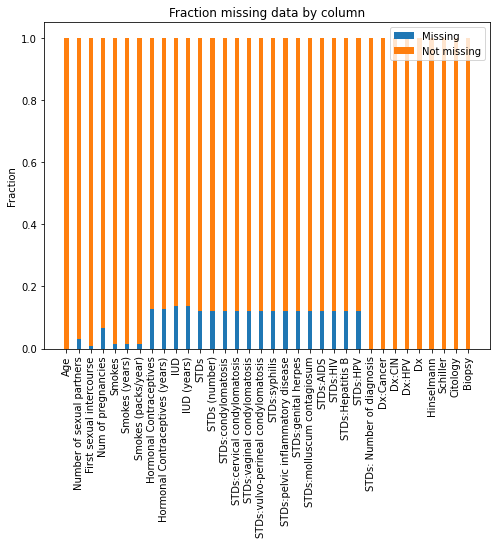

In [9]:
# plot
missings = np.zeros(data_drop.shape[1])
for colnum in range(data_drop.shape[1]):
    missings[colnum] = data_drop.iloc[:,colnum].isnull().sum() / data_drop.shape[0]

plt = miss_plt(missings, data_drop)
plt.savefig('plots/col_miss2.png')
plt.show()

<Figure size 432x288 with 0 Axes>

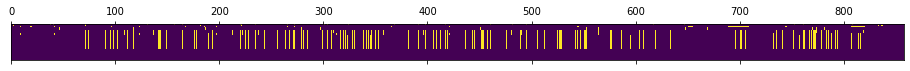

<Figure size 432x288 with 0 Axes>

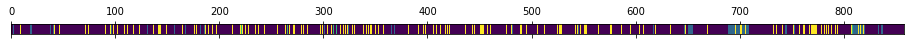

Data shape:  (858, 34)


In [10]:
# plot by sample
missings = np.zeros((data_drop.shape[0], data_drop.shape[1] + 1))
for colnum in range(data_drop.shape[1]):
    colcurr = data_drop.iloc[:,colnum]
    missings[:,colnum] = data_drop.iloc[:,colnum].isnull().astype('int')

plt.figure()
plt.matshow(missings.T, cmap = 'viridis')
plt.yticks([])
plt.savefig('plots/missings1.png')
plt.figure()

summed = np.sum(missings, 1)[:,np.newaxis]
plt.matshow(np.repeat(summed, 10, axis = 1).T, cmap = 'viridis', vmin = 0, vmax = 3)
plt.yticks([])
plt.savefig('plots/missings2.png')
plt.show()

print('Data shape: ', data_drop.shape)

In [11]:
# drop extra data rows which contain missing observations
data_drop = data_drop.dropna()
print('Data shape: ', data_drop.shape)

Data shape:  (668, 34)


In [12]:
# train test split
train_id = int(config['train-size-coefficient'] * data_drop.shape[0])
idx = data_drop.index.values
np.random.seed(0)
np.random.shuffle(idx)
train = data_drop.loc[idx[:train_id],:]
test = data_drop.loc[idx[train_id:],:]
print('Train_Data shape: ', train.shape)
print('Test_Data shape: ', test.shape)
train.to_csv('train.csv')
test.to_csv('test.csv')

Train_Data shape:  (467, 34)
Test_Data shape:  (201, 34)


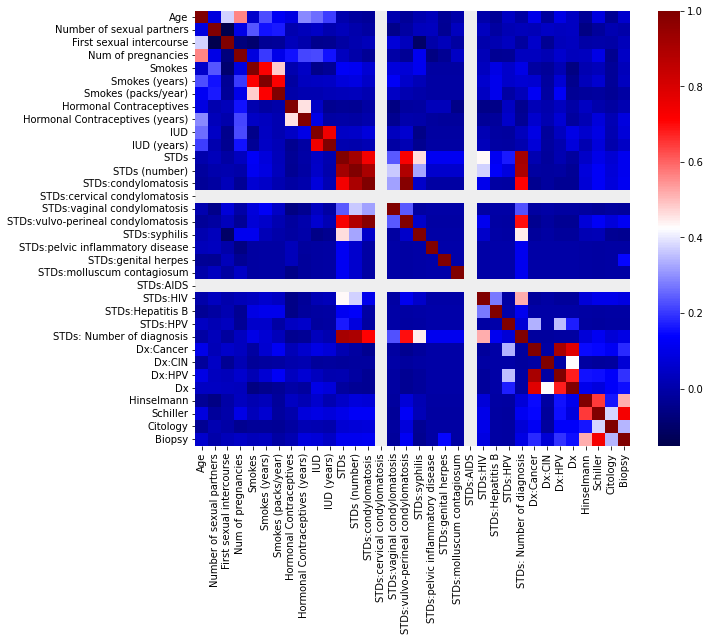

In [13]:
f,a = simple_ax(figsize = (10, 8))
sns.heatmap(data_drop.corr(), vmax = 1, square = True, cmap = 'seismic')
plt.savefig('plots/correlations.png')
plt.show()

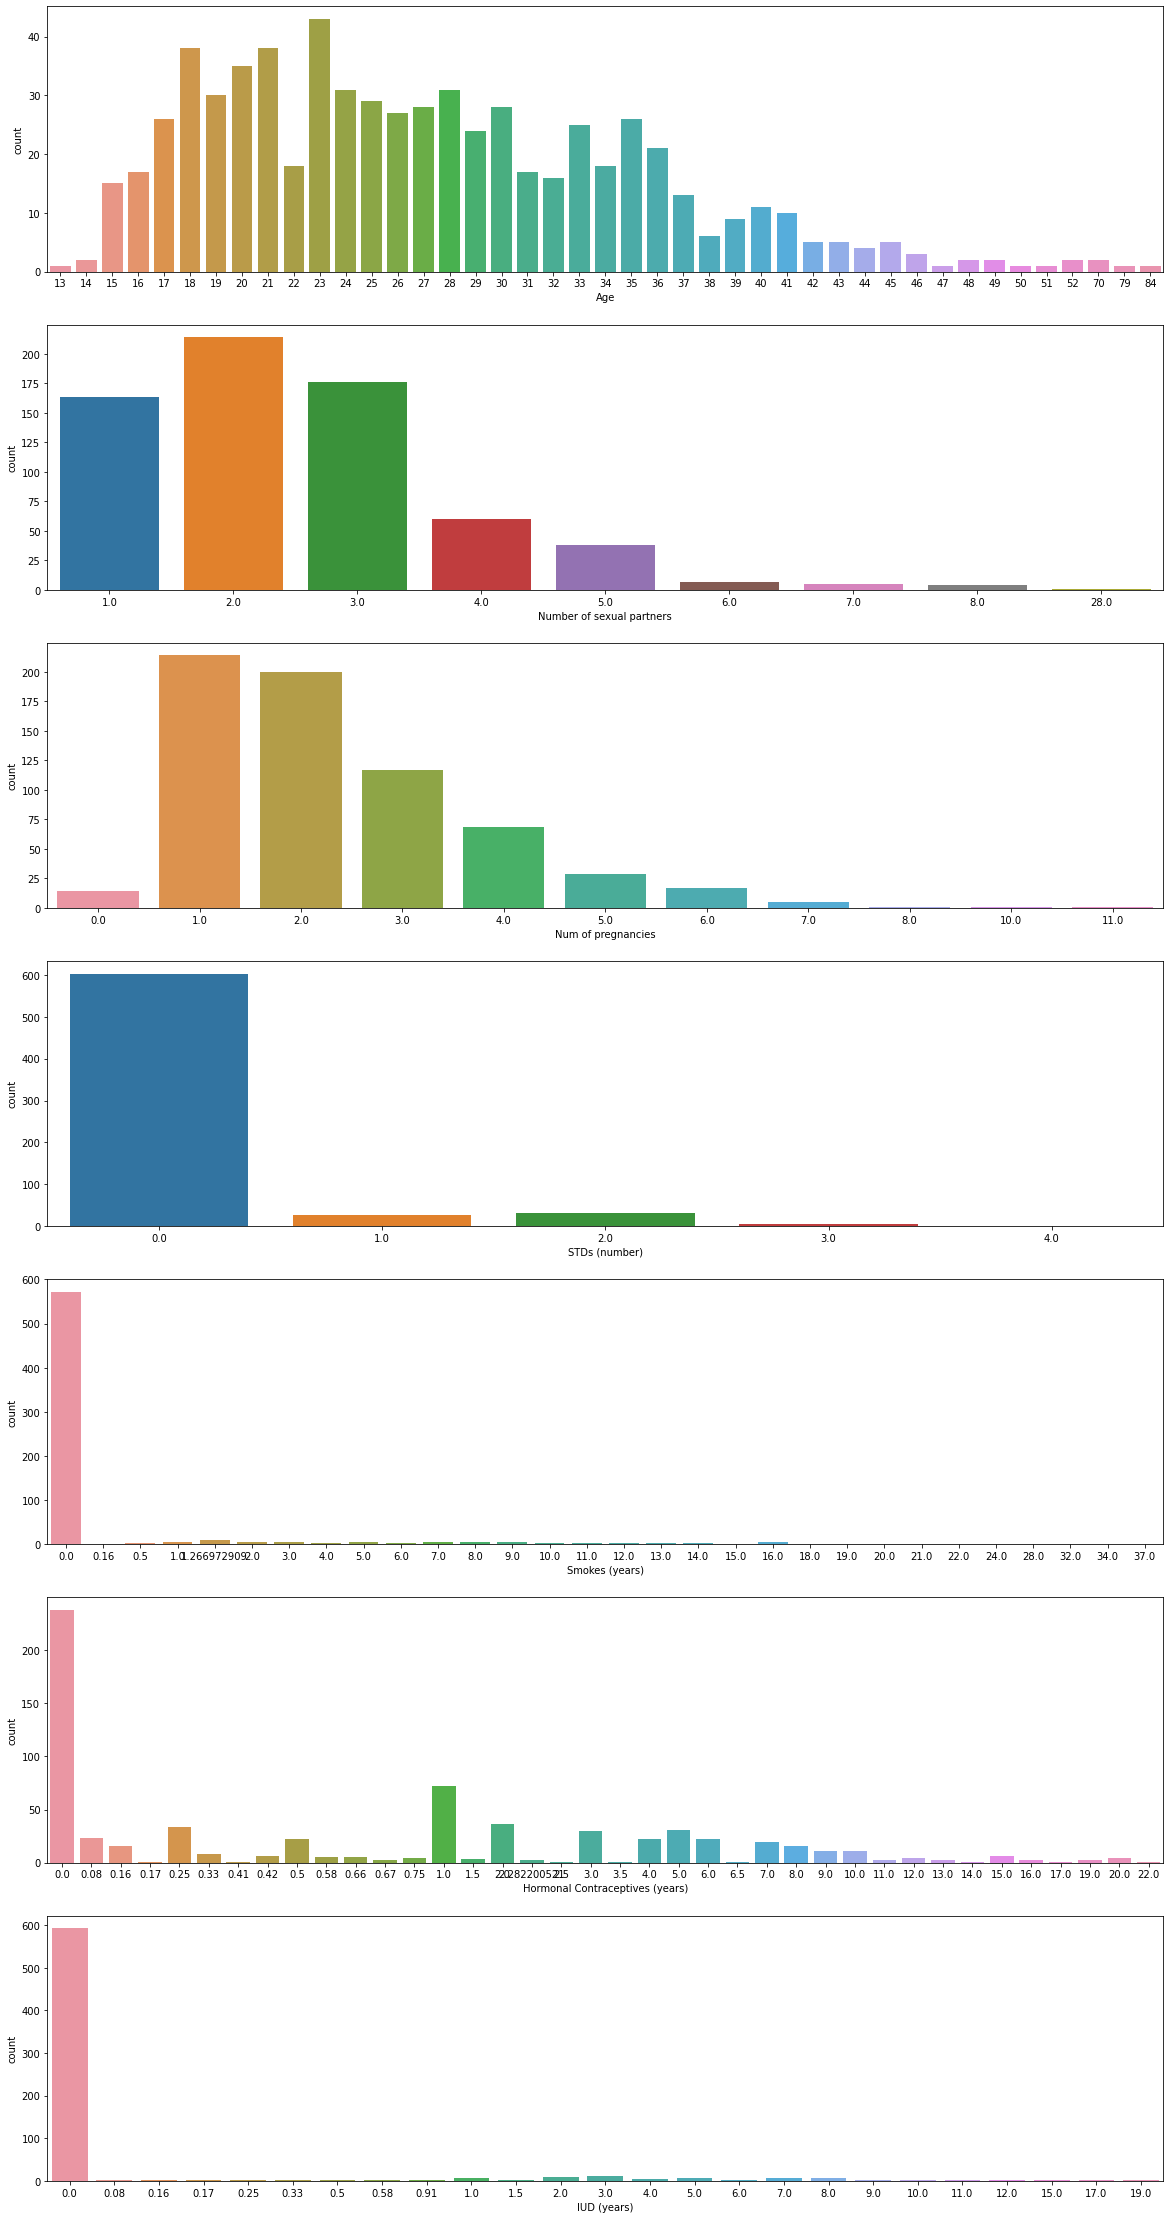

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize = (20, 40))
sns.countplot(x = data_drop['Age'], ax = ax1)
sns.countplot(x = data_drop['Number of sexual partners'], ax = ax2)
sns.countplot(x = data_drop['Num of pregnancies'], ax = ax3)
sns.countplot(x = data_drop['STDs (number)'], ax = ax4)
sns.countplot(x = data_drop['Smokes (years)'], ax = ax5)
sns.countplot(x = data_drop['Hormonal Contraceptives (years)'], ax = ax6)
sns.countplot(x = data_drop['IUD (years)'], ax = ax7)
plt.savefig('plots/data_peek.png')
plt.show()

*Out of all the recommended diagnosis procedures (Hinselmann, Schiller, Citology and Biopsy: target variables) we use recommendation of a biopsy by an oncologist as the metric for potential cancer risk, because biopsy is generally recommended only when there is a significantly high
perceived risk of cancer. By itself, a biopsy is an expensive and invasive procedure and we believe that a
model that captures this information can be valuable to a patient before they choose to undertake this
expensive procedure. *

## Build Neural Network Perceptron Model

In [15]:
X_train = train.iloc[:,:-4].values
y_train = train.iloc[:,-4:].values
X_test = test.iloc[:,:-4].values
y_test = test.iloc[:,-4:].values
print('X_train:', X_train.shape, '| y_train:', y_train.shape)
print('X_test:', X_test.shape, '| y_test:', y_test.shape)

X_train: (467, 30) | y_train: (467, 4)
X_test: (201, 30) | y_test: (201, 4)


In [16]:
y_test[:,3].sum()

16

In [17]:
best = ()
i = 1
for nodes in config['nodes']:
    for weight in config['weights']:
        for epochs in config['epochs']:
            model = Sequential()
            model.add(Dense(nodes, input_dim = X_train.shape[1]))
            model.add(Activation('relu'))
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
            weights = {0: 1., 1: weight}
            history = model.fit(X_train, y_train[:,3], epochs = epochs, class_weight = weights, verbose = 0)
            decs = model.predict(X_test)
            roc = roc_curve(y_test[:,3], decs)
            auc = roc_auc_score(y_test[:,3], decs)
            if best == () or auc > best[0]:
                best = (auc, roc, history, model, nodes, weight, epochs)
            print (i, '/ 105 done.')
            i += 1

1 / 105 done.
2 / 105 done.
3 / 105 done.
4 / 105 done.
5 / 105 done.
6 / 105 done.
7 / 105 done.
8 / 105 done.
9 / 105 done.
10 / 105 done.
11 / 105 done.
12 / 105 done.
13 / 105 done.
14 / 105 done.
15 / 105 done.
16 / 105 done.
17 / 105 done.
18 / 105 done.
19 / 105 done.
20 / 105 done.
21 / 105 done.
22 / 105 done.
23 / 105 done.
24 / 105 done.
25 / 105 done.
26 / 105 done.
27 / 105 done.
28 / 105 done.
29 / 105 done.
30 / 105 done.
31 / 105 done.
32 / 105 done.
33 / 105 done.
34 / 105 done.
35 / 105 done.
36 / 105 done.
37 / 105 done.
38 / 105 done.
39 / 105 done.
40 / 105 done.
41 / 105 done.
42 / 105 done.
43 / 105 done.
44 / 105 done.
45 / 105 done.
46 / 105 done.
47 / 105 done.
48 / 105 done.
49 / 105 done.
50 / 105 done.
51 / 105 done.
52 / 105 done.
53 / 105 done.
54 / 105 done.
55 / 105 done.
56 / 105 done.
57 / 105 done.
58 / 105 done.
59 / 105 done.
60 / 105 done.
61 / 105 done.
62 / 105 done.
63 / 105 done.
64 / 105 done.
65 / 105 done.
66 / 105 done.
67 / 105 done.
68 /

In [18]:
(auc, roc, history, model, nodes, weight, epochs) = best
print ("Nodes:", nodes, "| Weight:", weight, "| Epochs:", epochs)

Nodes: 24 | Weight: 25.0 | Epochs: 100


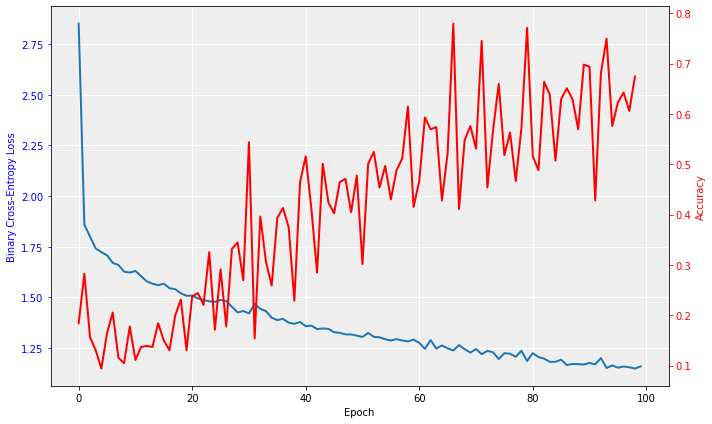

In [19]:
# plot errors
fig, ax1 = simple_ax(figsize=(10, 6))
ax1.plot(history.history['loss'], label = 'loss', linewidth = 2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Cross-Entropy Loss', color = 'b')
ax1.tick_params('y', colors = 'b')

ax2 = ax1.twinx()
plt.plot(history.history['accuracy'][1:], 'r-', label = 'accuracy', linewidth = 2)
ax2.set_ylabel('Accuracy', color = 'r')
ax2.tick_params('y', colors = 'r')

fig.tight_layout()
plt.savefig('plots/error2.png')
plt.show()

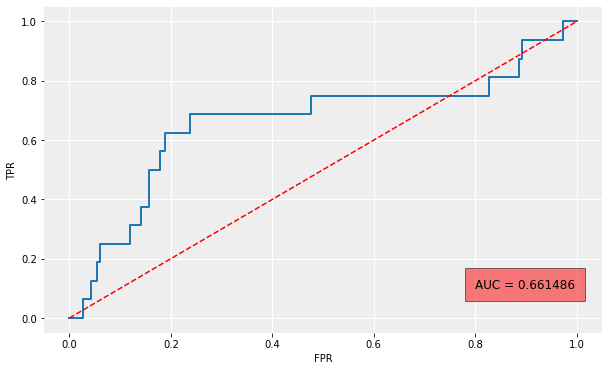

In [20]:
decs = model.predict(X_test)
plt = roc_plt(y_test, decs)
plt.savefig('plots/mlp_roc.png')
plt.show()

## Logistic Regression

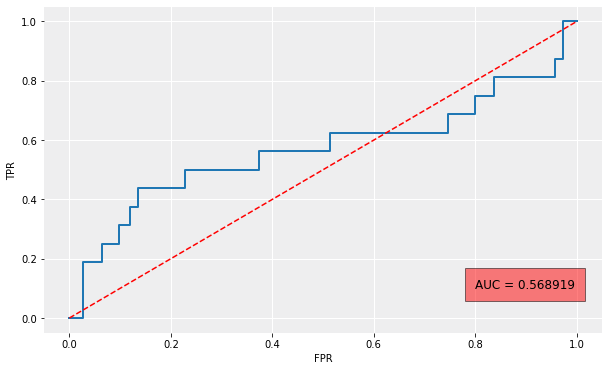

In [21]:
logistic = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
logistic.fit(X_train, y_train[:,3])
decs = logistic.decision_function(X_test)
plt = roc_plt(y_test, decs)
plt.savefig('plots/logistic_roc.png')
plt.show()

## Ridge Regression

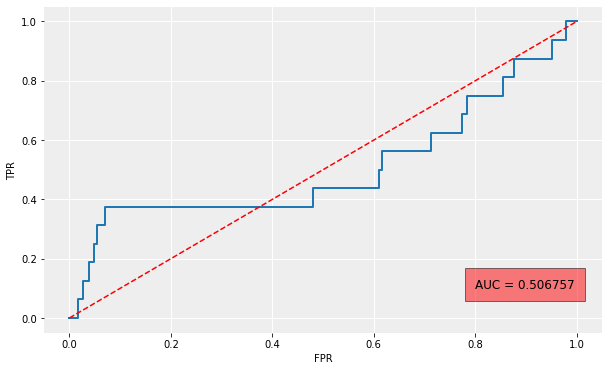

In [22]:
ridge = make_pipeline(StandardScaler(with_mean = False), RidgeClassifier())
ridge.fit(X_train, y_train[:,3])
decs = ridge.decision_function(X_test)
plt = roc_plt(y_test, decs)
plt.savefig('plots/ridge_roc.png')
plt.show()

## Random Forest

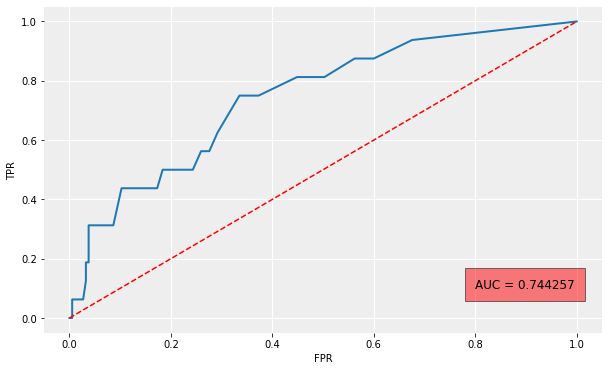

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train[:,3])
decs = rf.predict_proba(X_test)[:,1]
plt = roc_plt(y_test, decs)
plt.savefig('plots/rf_roc.png')
plt.show()